In [162]:
import collections
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model

In [163]:
jobs_data = [  # task = (machine_id, processing_time).
    [(0, 3), (1, 2), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 0
    [(0, 2), (1, 1), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 1
    [(0, 4), (1, 3), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 2
    [(0, 4), (1, 3), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 3
    [(0, 4), (1, 3), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 4
    [(0, 4), (1, 3), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 5
    [(0, 4), (1, 3), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3)],  # Subject 6
]

machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)
# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)

In [164]:
model = cp_model.CpModel()

In [165]:
# Named tuple to store information about created variables.
task_type = collections.namedtuple("task_type", "start end interval")
# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple(
    "assigned_task_type", "start job index duration"
)

# Creates job intervals and add to the corresponding machine lists.
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine, duration = task
        suffix = f"_{job_id}_{task_id}"
        start_var = model.new_int_var(0, horizon, "start" + suffix)
        end_var = model.new_int_var(0, horizon, "end" + suffix)
        interval_var = model.new_interval_var(
            start_var, duration, end_var, "interval" + suffix
        )
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        machine_to_intervals[machine].append(interval_var)

In [166]:
for machine in all_machines:
    model.add_no_overlap(machine_to_intervals[machine])

# Precedences inside a job.
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        model.add(
            all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end
        )

In [167]:
# Makespan objective.
obj_var = model.new_int_var(0, horizon, "makespan")
model.add_max_equality(
    obj_var,
    [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
)
model.minimize(obj_var)

In [168]:
solver = cp_model.CpSolver()
status = solver.solve(model)

Solution:


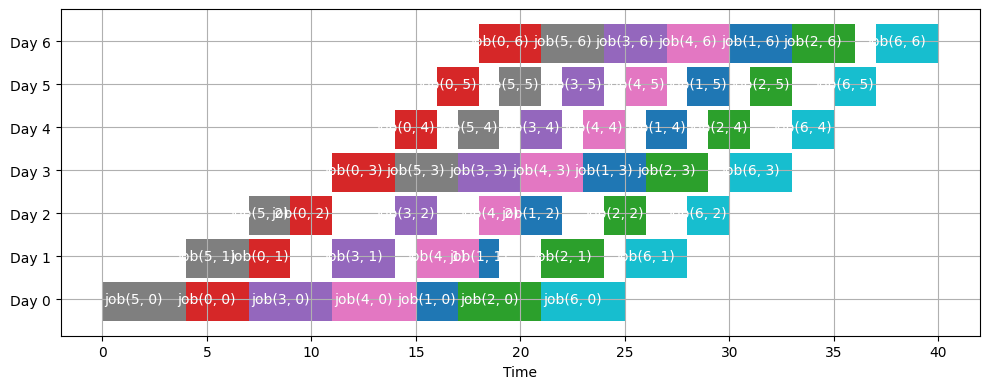

Optimal Schedule Length: 40.0
Day 0: Subject_5_session_0Subject_0_session_0Subject_3_session_0Subject_4_session_0Subject_1_session_0Subject_2_session_0Subject_6_session_0
           [0,4]          [4,7]          [7,11]         [11,15]        [15,17]        [17,21]        [21,25]        
Day 1: Subject_5_session_1Subject_0_session_1Subject_3_session_1Subject_4_session_1Subject_1_session_1Subject_2_session_1Subject_6_session_1
           [4,7]          [7,9]          [11,14]        [15,18]        [18,19]        [21,24]        [25,28]        
Day 2: Subject_5_session_2Subject_0_session_2Subject_3_session_2Subject_4_session_2Subject_1_session_2Subject_2_session_2Subject_6_session_2
           [7,9]          [9,11]         [14,16]        [18,20]        [20,22]        [24,26]        [28,30]        
Day 3: Subject_0_session_3Subject_5_session_3Subject_3_session_3Subject_4_session_3Subject_1_session_3Subject_2_session_3Subject_6_session_3
           [11,14]        [14,17]        [17,20]       

In [169]:
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Solution:")
    # Create one list of assigned tasks per machine.

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    machine_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:pink', 'tab:gray', 'tab:cyan']
    fig, ax = plt.subplots(figsize=(10, 4))

    for (job_id, task_id), task in all_tasks.items():
        machine, duration = jobs_data[job_id][task_id]
        start = solver.Value(task.start)
        ax.broken_barh([(start, duration)], (machine * 10, 9),
                       facecolors=machine_colors[job_id])
        ax.text(start + duration / 2 - 0.5, machine * 10 + 5,
                f'job({job_id}, {task_id})', color='white', ha='center', va='center')

    ax.set_yticks([10 * i + 5 for i in all_machines])
    ax.set_yticklabels([f'Day {i}' for i in all_machines])
    ax.set_xlabel('Time')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            assigned_jobs[machine].append(
                assigned_task_type(
                    start=solver.value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task[1],
                )
            )

    # Create per machine output lines.
    output = ""
    for machine in all_machines:
        # Sort by starting time.
        assigned_jobs[machine].sort()
        sol_line_tasks = "Day " + str(machine) + ": "
        sol_line = "           "

        for assigned_task in assigned_jobs[machine]:
            name = f"Subject_{assigned_task.job}_session_{assigned_task.index}"
            # add spaces to output to align columns.
            sol_line_tasks += f"{name:15}"

            start = assigned_task.start
            duration = assigned_task.duration
            sol_tmp = f"[{start},{start + duration}]"
            # add spaces to output to align columns.
            sol_line += f"{sol_tmp:15}"

        sol_line += "\n"
        sol_line_tasks += "\n"
        output += sol_line_tasks
        output += sol_line

    # Finally print the solution found.
    print(f"Optimal Schedule Length: {solver.objective_value}")
    print(output)
else:
    print("No solution found.")